In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
import torch
import json
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from utils import gen_padding_mask, metrics, random_mask_target, compute_length_loss
from seq2seqmodel import TransformerAutoEncoder
from tokenizer import Tokenizer
import random

In [46]:
# 檢查是否可用 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
    print(torch.cuda.get_device_properties(device))

    # 清除 CUDA 設備的未使用內存
    torch.cuda.empty_cache()
else:
    print("CUDA is not available. Using CPU.")

NVIDIA GeForce RTX 4070 SUPER
_CudaDeviceProperties(name='NVIDIA GeForce RTX 4070 SUPER', major=8, minor=9, total_memory=12281MB, multi_processor_count=56, uuid=25c21ef8-cd11-c18b-4083-56f7752b9683, L2_cache_size=48MB)


In [47]:
class PretrainDataset(Dataset):

    def __init__(self, root, tokenizer, padding=24, mask_prob=0.3):
        super(PretrainDataset, self).__init__()
        with open(os.path.join(root, 'words_dictionary.json'), 'r') as f:
            words_dict = json.load(f)
        
        # 將單字列表設為數據集
        self.words = list(words_dict.keys())
        self.tokenizer = tokenizer
        self.padding = padding
        self.mask_prob = mask_prob

    def tokenize(self, word):
        # 將單字轉換為 token id 序列
        token_ids = [self.tokenizer.char_2_index['[sos]']] + \
                    self.tokenizer.char_to_index(word) + \
                    [self.tokenizer.char_2_index['[eos]']]
        
        token_ids = token_ids[:self.padding]  # 截斷
        padded_ids = np.pad(token_ids, (0, max(0, self.padding - len(token_ids))), constant_values=self.tokenizer.pad_idx)
        return padded_ids
    
    def apply_mask(self, token_ids):
        masked_token_ids = token_ids.copy()
        
        for i in range(1, len(token_ids) - 1):  # 跳過 [sos] 和 [eos]
            if token_ids[i] == self.tokenizer.pad_idx:
                break  # 遇到 padding 停止

            if np.random.rand() < self.mask_prob:
                prob = np.random.rand()

                if prob < 0.7:
                    masked_token_ids[i] = self.tokenizer.mask_idx  # 70% 機率替換為 [mask]
                elif prob < 0.9:
                    masked_token_ids[i] = random.randint(0, 25)  # 10% 替換為隨機字符
                    
                # 10% 保持原字

        return masked_token_ids
    
    def __len__(self):
        # 返回數據集的單字數量
        return len(self.words)

    def __getitem__(self, index):
        word = self.words[index]
        input_text = self.tokenize(word)
        target_text = self.tokenize(word)

        masked_input = self.apply_mask(input_text)

        src_ids = torch.tensor(masked_input, dtype=torch.long)
        tgt_ids = torch.tensor(target_text, dtype=torch.long)

        return src_ids, tgt_ids

In [48]:
tokenizer = Tokenizer()

PAD_IDX = tokenizer.pad_idx
SOS_IDX = tokenizer.sos_idx
EOS_IDX = tokenizer.eos_idx
MASK_IDX = tokenizer.mask_idx

In [ ]:
def pretrain_encoder(dataloader, model, optimizer, criterion, init_sampling_prob=0.8, sampling_decay_rate=0.1, num_epochs=10, scheduler=None, logout=False):

    loss_records = []
    accuracy_records = []
    sampling_prob = init_sampling_prob

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        total_accuracy = 0
        
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}') 
        for src_ids, tgt_ids in progress_bar:
            src_ids, tgt_ids = src_ids.to(device), tgt_ids.to(device)  # [batch_size, sequence_length]

            # 遮蔽目標單字
            tgt_ids_masked = random_mask_target(tgt_ids.clone(), sampling_prob, PAD_IDX, SOS_IDX)
 
            src_pad_mask = gen_padding_mask(src_ids, PAD_IDX).to(device)
            tgt_pad_mask = gen_padding_mask(tgt_ids_masked, PAD_IDX).to(device)

            optimizer.zero_grad()

            # 前向傳播
            output = model(src_ids, tgt_ids_masked, src_pad_mask, tgt_pad_mask)  # [batch_size, sequence_length, vocab_size]

            # 計算損失
            ce_loss = criterion(output.view(-1, output.size(-1)), tgt_ids.view(-1))
            length_loss = compute_length_loss(output.argmax(dim=-1), tgt_ids, EOS_IDX)

            total_loss_batch = ce_loss + 0.1 * length_loss
            total_loss_batch.backward()
            optimizer.step()
            total_loss += total_loss_batch.item()
                
            # 計算準確率
            pred = output.argmax(dim=-1)  # [batch_size, sequence_length]
            
            pred_str_batch = [
                tokenizer.index_to_char(pred[i], without_token=True)
                for i in range(pred.size(0))
            ]
            target_str_batch = [
                tokenizer.index_to_char(tgt_ids[i], without_token=True)
                for i in range(tgt_ids.size(0))
            ]

            total_accuracy += metrics(pred_str_batch, target_str_batch)

            if logout:
                print('='*30)
                print(f'src: {tokenizer.index_to_char(src_ids[-1], without_token=True)}')
                print(f'pred: {pred_str_batch[-1]}')
                print(f'target: {target_str_batch[-1]}')
                        
        if scheduler:
            scheduler.step()

        sampling_prob *= (1- sampling_decay_rate)

        avg_loss = total_loss / len(dataloader)
        avg_accuracy = total_accuracy / len(dataloader)
        loss_records.append(avg_loss)
        accuracy_records.append(avg_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%")
    
    return loss_records, accuracy_records

In [51]:
embedding_num = 31
embedding_dim = 512
num_layers = 8
num_heads = 4
ff_dim = 1024
dropout = 0.2
padding=24
learning_rate=0.0001

In [52]:
model = TransformerAutoEncoder(embedding_num, embedding_dim, num_layers, num_heads, ff_dim, dropout, padding).to(device)
ce_loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
epochs=20
batch_size=128
mask_prob=0.3
init_sampling_prob=0.5
sampling_decay_rate=0

In [ ]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=2, gamma=0.9)

In [55]:
pretrain_dataset = PretrainDataset('./data/', tokenizer=tokenizer, padding=padding, mask_prob=mask_prob)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=batch_size, shuffle=True)

# 訓練模型
loss_records, accuracy_records = pretrain_encoder(
    pretrain_loader,
    model=model,
    optimizer=optimizer,
    criterion=ce_loss,
    init_sampling_prob=init_sampling_prob,
    sampling_decay_rate=sampling_decay_rate,
    num_epochs=epochs,
    scheduler=scheduler,
    logout=False
)

Epoch 1/20: 100%|██████████| 2892/2892 [05:39<00:00,  8.51it/s]


Epoch 1/20, Loss: 0.7757, Accuracy: 23.06%


Epoch 2/20: 100%|██████████| 2892/2892 [05:39<00:00,  8.52it/s]


Epoch 2/20, Loss: 0.3288, Accuracy: 36.73%


Epoch 3/20: 100%|██████████| 2892/2892 [05:39<00:00,  8.52it/s]


Epoch 3/20, Loss: 0.3032, Accuracy: 39.06%


Epoch 4/20: 100%|██████████| 2892/2892 [05:36<00:00,  8.59it/s]


Epoch 4/20, Loss: 0.2925, Accuracy: 40.26%


Epoch 5/20: 100%|██████████| 2892/2892 [05:35<00:00,  8.63it/s]


Epoch 5/20, Loss: 0.2802, Accuracy: 41.72%


Epoch 6/20: 100%|██████████| 2892/2892 [05:35<00:00,  8.61it/s]


Epoch 6/20, Loss: 0.2746, Accuracy: 42.34%


Epoch 7/20: 100%|██████████| 2892/2892 [05:35<00:00,  8.63it/s]


Epoch 7/20, Loss: 0.2672, Accuracy: 43.21%


Epoch 8/20: 100%|██████████| 2892/2892 [05:35<00:00,  8.63it/s]


Epoch 8/20, Loss: 0.2626, Accuracy: 43.80%


Epoch 9/20: 100%|██████████| 2892/2892 [05:33<00:00,  8.68it/s]


Epoch 9/20, Loss: 0.2570, Accuracy: 44.54%


Epoch 10/20: 100%|██████████| 2892/2892 [05:32<00:00,  8.69it/s]


Epoch 10/20, Loss: 0.2540, Accuracy: 45.04%


Epoch 11/20: 100%|██████████| 2892/2892 [05:33<00:00,  8.66it/s]


Epoch 11/20, Loss: 0.2504, Accuracy: 45.45%


Epoch 12/20: 100%|██████████| 2892/2892 [05:35<00:00,  8.62it/s]


Epoch 12/20, Loss: 0.2476, Accuracy: 45.85%


Epoch 13/20: 100%|██████████| 2892/2892 [05:36<00:00,  8.60it/s]


Epoch 13/20, Loss: 0.2436, Accuracy: 46.34%


Epoch 14/20: 100%|██████████| 2892/2892 [05:38<00:00,  8.55it/s]


Epoch 14/20, Loss: 0.2432, Accuracy: 46.49%


Epoch 15/20: 100%|██████████| 2892/2892 [05:35<00:00,  8.63it/s]


Epoch 15/20, Loss: 0.2386, Accuracy: 47.14%


Epoch 16/20: 100%|██████████| 2892/2892 [05:28<00:00,  8.80it/s]


Epoch 16/20, Loss: 0.2380, Accuracy: 47.25%


Epoch 17/20: 100%|██████████| 2892/2892 [05:33<00:00,  8.67it/s]


Epoch 17/20, Loss: 0.2344, Accuracy: 47.72%


Epoch 18/20: 100%|██████████| 2892/2892 [05:33<00:00,  8.67it/s]


Epoch 18/20, Loss: 0.2337, Accuracy: 47.90%


Epoch 19/20: 100%|██████████| 2892/2892 [05:34<00:00,  8.66it/s]


Epoch 19/20, Loss: 0.2319, Accuracy: 48.11%


Epoch 20/20: 100%|██████████| 2892/2892 [05:34<00:00,  8.65it/s]

Epoch 20/20, Loss: 0.2300, Accuracy: 48.30%


In [68]:
def plot_loss_acc(loss, acc):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # 左 y 軸：損失曲線
    ax1.plot(loss, label='Loss', color='tab:red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.set_title('Training Loss and Accuracy over Epochs')

    # 右 y 軸：準確率曲線
    ax2 = ax1.twinx()
    ax2.plot(acc, label='Accuracy', color='tab:blue')
    ax2.set_ylabel('Accuracy (%)', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 顯示圖例
    fig.tight_layout()
    plt.show()

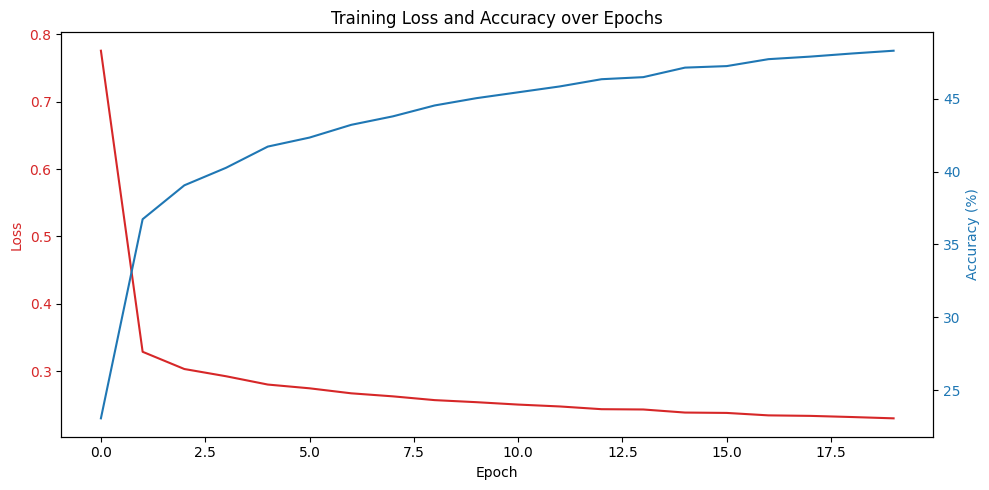

In [69]:
plot_loss_acc(loss_records, accuracy_records)

In [63]:
model_config = {
    "num_emb": embedding_num,
    "hid_dim": embedding_dim,
    "n_layers": num_layers,
    "n_heads": num_heads,
    "ff_dim": ff_dim,
    "dropout": dropout,
    "max_length": padding
}

checkpoint = {
    "model_state_dict": model.state_dict(),  # 模型權重
    "model_config": model_config              # 模型架構參數
}

torch.save(checkpoint, 'pretrain_para.pth')